In [3]:
import pandas as pd

In [5]:
file_path="./data/city_day.csv"
df=pd.read_csv(file_path)

In [6]:
display(df.head())

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [7]:
#Selecting required columns
required_columns = ["City", "Date", "PM2.5", "NO", "NO2", "NOx", "CO", "SO2", "O3", "AQI"]
df_cleaned = df[required_columns].copy()

In [8]:
#Convert Date column to datetime format
df_cleaned["Date"] = pd.to_datetime(df_cleaned["Date"], errors="coerce")

In [9]:
#Drop rows where City or Date is missing
df_cleaned = df_cleaned.dropna(subset=["City", "Date"])

In [11]:
# Handle missing values in other columns
# First, use forward fill (ffill) and then backward fill (bfill)
# Use forward fill and backward fill explicitly specifying axis=0
df_cleaned.fillna(method='ffill', axis=0, inplace=True)
df_cleaned.fillna(method='bfill', axis=0, inplace=True)


C:\Users\Vidhi\AppData\Local\Temp\ipykernel_20272\1355860458.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned.fillna(method='ffill', axis=0, inplace=True)
C:\Users\Vidhi\AppData\Local\Temp\ipykernel_20272\1355860458.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned.fillna(method='bfill', axis=0, inplace=True)


In [13]:
output_file_path="./data/air_quality_data.csv"
df_cleaned.to_csv(output_file_path, index=False)

In [15]:
print(f"Cleaned data saved to {output_file_path}")

Cleaned data saved to ./data/air_quality_data.csv


In [17]:
"# Fuzzy Logic-Based AQI Calculation and Time Series Prediction\n"
"This notebook calculates AQI using fuzzy logic, compares it with the provided AQI, calculates error, classifies AQI into categories, and predicts future AQI using ARIMA."

'This notebook calculates AQI using fuzzy logic, compares it with the provided AQI, calculates error, classifies AQI into categories, and predicts future AQI using ARIMA.'

In [21]:
"#Import Libraries"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
   

In [22]:
"#Load Data"
data = pd.read_csv('./data/air_quality_data.csv')
data['Date'] = pd.to_datetime(data['Date'])  # Convert Date to datetime
data.head()

,City,Date,PM2.5,NO,NO2,NOx,CO,SO2,O3,AQI
0,Ahmedabad,2015-01-01,73.24,0.92,18.22,17.15,0.92,27.64,133.36,209.0
1,Ahmedabad,2015-01-02,73.24,0.97,15.69,16.46,0.97,24.55,34.06,209.0
2,Ahmedabad,2015-01-03,73.24,17.40,19.30,29.70,17.40,29.07,30.70,209.0
3,Ahmedabad,2015-01-04,73.24,1.70,18.48,17.97,1.70,18.59,36.08,209.0
4,Ahmedabad,2015-01-05,73.24,22.10,21.42,37.76,22.10,39.33,39.31,209.0


In [23]:
#Define Fuzzy Logic Functions
# Triangular membership function
def triangular_mf(x, a, b, c):
    if x <= a or x >= c:
        return 0
    elif a < x <= b:
        return (x - a) / (b - a)
    elif b < x < c:
        return (c - x) / (c - b)
    return 0

# PM2.5 membership functions (µg/m³)
def pm25_low(x): return triangular_mf(x, 0, 0, 50)
def pm25_moderate(x): return triangular_mf(x, 0, 50, 100)
def pm25_unhealthy(x): return triangular_mf(x, 50, 100, 150)
def pm25_very_unhealthy(x): return triangular_mf(x, 100, 150, 300)

# NO2 membership functions (µg/m³)
def no2_low(x): return triangular_mf(x, 0, 0, 40)
def no2_moderate(x): return triangular_mf(x, 0, 40, 80)
def no2_high(x): return triangular_mf(x, 40, 80, 150)

# AQI output membership functions
def aqi_good(x): return triangular_mf(x, 0, 0, 50)
def aqi_moderate(x): return triangular_mf(x, 0, 50, 100)
def aqi_unhealthy_sensitive(x): return triangular_mf(x, 50, 100, 150)
def aqi_unhealthy(x): return triangular_mf(x, 100, 150, 200)
def aqi_very_unhealthy(x): return triangular_mf(x, 150, 200, 300)
def aqi_hazardous(x): return triangular_mf(x, 200, 300, 500)

# Fuzzification
def fuzzify(value, membership_funcs):
    return {label: func(value) for label, func in membership_funcs.items()}

pm25_funcs = {
    'low': pm25_low,
    'moderate': pm25_moderate,
    'unhealthy': pm25_unhealthy,
    'very_unhealthy': pm25_very_unhealthy
}

no2_funcs = {
    'low': no2_low,
    'moderate': no2_moderate,
    'high': no2_high
}

# Fuzzy rules
rules = [
    {'conditions': [('pm25', 'low'), ('no2', 'low')], 'output': 'good'},
    {'conditions': [('pm25', 'moderate'), ('no2', 'moderate')], 'output': 'moderate'},
    {'conditions': [('pm25', 'unhealthy'), ('no2', 'high')], 'output': 'unhealthy'},
    {'conditions': [('pm25', 'very_unhealthy'), ('no2', 'high')], 'output': 'very_unhealthy'},
]

# Rule evaluation
def evaluate_rule(rule, fuzzy_inputs):
    strength = min(fuzzy_inputs[var][label] for var, label in rule['conditions'])
    return strength, rule['output']

# Aggregation
def aggregate(rules_output):
    aggregated = {}
    for strength, output in rules_output:
        aggregated[output] = max(aggregated.get(output, 0), strength)
    return aggregated

# Defuzzification
def defuzzify(aggregated, aqi_ranges):
    numerator = 0
    denominator = 0
    for label, strength in aggregated.items():
        center = (aqi_ranges[label][0] + aqi_ranges[label][1]) / 2
        numerator += center * strength
        denominator += strength
    return numerator / denominator if denominator != 0 else 0

aqi_ranges = {
    'good': (0, 50),
    'moderate': (51, 100),
    'unhealthy_sensitive': (101, 150),
    'unhealthy': (151, 200),
    'very_unhealthy': (201, 300),
    'hazardous': (301, 500)
}

# Predict AQI
def predict_aqi(pm25, no2):
    pm25_fuzzy = fuzzify(pm25, pm25_funcs)
    no2_fuzzy = fuzzify(no2, no2_funcs)
    fuzzy_inputs = {'pm25': pm25_fuzzy, 'no2': no2_fuzzy}
    rules_output = [evaluate_rule(rule, fuzzy_inputs) for rule in rules]
    aggregated = aggregate(rules_output)
    return defuzzify(aggregated, aqi_ranges)

    

In [24]:
#Calculate AQI and compare with provided AQI
# Calculate predicted AQI for each row
data['Predicted_AQI'] = data.apply(lambda row: predict_aqi(row['PM2.5'], row['NO2']), axis=1)

# Calculate error (Mean Absolute Error)
data['Error'] = abs(data['AQI'] - data['Predicted_AQI'])
mae = data['Error'].mean()
print(f'Mean Absolute Error: {mae:.2f}')

# Classify Predicted AQI
def classify_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

data['AQI_Category'] = data['Predicted_AQI'].apply(classify_aqi)
data[['Date', 'City', 'PM2.5', 'NO2', 'AQI', 'Predicted_AQI', 'Error', 'AQI_Category']].head()


Mean Absolute Error: 95.60


,Date,City,PM2.5,NO2,AQI,Predicted_AQI,Error,AQI_Category
0,2015-01-01,Ahmedabad,73.24,18.22,209.0,75.5,133.5,Moderate
1,2015-01-02,Ahmedabad,73.24,15.69,209.0,75.5,133.5,Moderate
2,2015-01-03,Ahmedabad,73.24,19.30,209.0,75.5,133.5,Moderate
3,2015-01-04,Ahmedabad,73.24,18.48,209.0,75.5,133.5,Moderate
4,2015-01-05,Ahmedabad,73.24,21.42,209.0,75.5,133.5,Moderate


c:\Users\Vidhi\Desktop\AQI\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Vidhi\Desktop\AQI\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Vidhi\Desktop\AQI\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


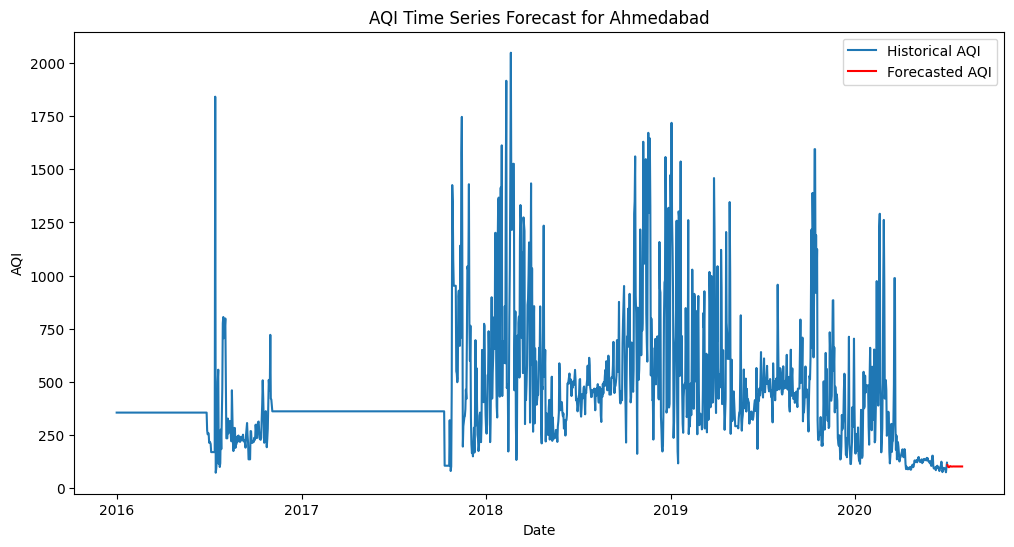

In [25]:
#Time Series Prediction with ARIMA
# Filter data for Ahmedabad (example city) from 2016-2020
city_data = data[(data['City'] == 'Ahmedabad') & (data['Date'].dt.year >= 2016) & (data['Date'].dt.year <= 2020)]
ts_data = city_data.set_index('Date')['AQI']

# Train ARIMA model (p=5, d=1, q=0) - adjust parameters as needed
model = ARIMA(ts_data, order=(5, 1, 0))
model_fit = model.fit()

# Forecast next 30 days
forecast = model_fit.forecast(steps=30)
forecast_dates = pd.date_range(start=ts_data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecasted_AQI': forecast})

# Plot historical and forecasted AQI
plt.figure(figsize=(12, 6))
plt.plot(ts_data, label='Historical AQI')
plt.plot(forecast_df['Date'], forecast_df['Forecasted_AQI'], label='Forecasted AQI', color='red')
plt.title('AQI Time Series Forecast for Ahmedabad')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()


In [26]:
#Save Results
# Save processed data with predictions
data.to_csv('data/processed_air_quality_data.csv', index=False)
forecast_df.to_csv('data/forecasted_aqi_ahmedabad.csv', index=False)
